In [16338]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import copy

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBRegressor
from xgboost import XGBClassifier

import statsmodels.api as sm

import datetime

In [16339]:
np.random.seed(4)

In [16340]:
def preprocess_transaction_flag(df):
    df['transaction_flag'] = df['transaction_count'].apply(lambda x: 1 if x > 0 else 0)
    return df

def calculate_mdd(cumulative_returns):
    """
    Maximum Drawdown (MDD) 계산 함수
    :param cumulative_returns: 누적 수익률 (1 + 전략 수익률).cumprod() 형태의 데이터
    :return: MDD (최대 낙폭)
    """
    peak = np.maximum.accumulate(cumulative_returns)  # 최고점 누적 기록
    drawdown = (cumulative_returns - peak) / peak  # 각 시점의 손실 비율
    mdd = drawdown.min()  # 최대 손실율 (음수 값)
    return mdd

In [16341]:
# 학습용 데이터 읽기
test_df = pd.read_csv("data/test/test_df.csv")
test_df

,date,transaction_count,transaction_amount,transaction_flag,returns,close,abs_returns,volume,open,high,...,n-transactions-total,n-transactions,n-unique-addresses,output-volume,trade-volume,transaction-fees-usd,transaction-fees,n-payments-per-block,n-payments,avg-confirmation-time
0,2017-01-01,0,0.000000e+00,0,NaN,4285.08,NaN,795.150377,4261.48,4485.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-02,0,0.000000e+00,0,-0.041238,4108.37,0.041238,1199.888264,4285.08,4371.52,...,1.839618e+08,290951.0,529709.0,1.573982e+06,6.822471e+06,114872.988609,112.884147,NaN,NaN,NaN
2,2017-01-03,0,0.000000e+00,0,0.007694,4139.98,0.007694,381.309763,4108.37,4184.69,...,1.842534e+08,301664.0,515024.0,1.950525e+06,8.324526e+06,120759.971352,117.508697,NaN,NaN,NaN
3,2017-01-04,0,0.000000e+00,0,-0.012969,4086.29,0.012969,467.083022,4139.98,4211.08,...,1.845561e+08,328642.0,545609.0,2.482038e+06,9.340584e+06,214902.266038,193.337436,NaN,NaN,NaN
4,2017-01-05,1,3.936639e+13,1,-0.017201,4016.00,0.017201,691.743060,4086.29,4119.62,...,1.848845e+08,288501.0,495910.0,2.998215e+06,2.387011e+07,121958.044759,114.991943,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,2024-09-26,0,0.000000e+00,0,0.032018,65173.99,0.032018,28373.305930,63152.01,65839.00,...,1.086041e+09,474766.0,515965.0,8.415049e+05,NaN,568078.359074,8.530836,6348.207692,825267.0,190.793990
2826,2024-09-27,1,1.076363e+12,1,0.009144,65769.95,0.009144,22048.804870,65173.99,66498.00,...,1.086516e+09,451723.0,549045.0,8.076291e+05,NaN,734594.752719,11.071403,6157.496350,843577.0,61.365461
2827,2024-09-28,0,0.000000e+00,0,0.001339,65858.00,0.001339,9127.233160,65769.95,66260.00,...,1.086966e+09,507707.0,477266.0,4.624474e+05,NaN,667521.876248,10.057609,6670.612403,860509.0,75.537497
2828,2024-09-29,0,0.000000e+00,0,-0.003887,65602.01,0.003887,8337.741110,65858.00,66076.12,...,1.087474e+09,687427.0,462111.0,4.892956e+05,NaN,496190.298458,7.532710,6508.270968,1008782.0,127.982783


In [16342]:
# target df 읽기

columns = ['date', 'transaction_count', 'transaction_amount', 'transaction_flag']

target_event_receive_df = pd.read_csv("./data/target/event_2_day_transactions_over_100_threshold_500_receive.csv")

# target_event_receive_df = pd.read_csv("./data/target/wallet_ranking_target_named_250110.csv")
target_event_send_df = pd.read_csv("./data/target/event_2_day_transactions_over_130_send.csv")

target_event_receive_df = preprocess_transaction_flag(target_event_receive_df)
target_event_send_df = preprocess_transaction_flag(target_event_send_df)

target_event_receive_df.columns = columns
target_event_send_df.columns = columns

In [16343]:
target_event_difference_df = target_event_receive_df.copy()
target_event_difference_df['transaction_count'] = (target_event_receive_df['transaction_count'] - target_event_send_df['transaction_count'])
target_event_difference_df['transaction_amount'] = (target_event_receive_df['transaction_amount'] - target_event_send_df['transaction_amount'])
target_event_difference_df['transaction_flag'] = target_event_difference_df['transaction_amount'].apply(
    lambda x: 1 if x > 0 else (0 if x == 0 else -1)
)
target_event_difference_df


,date,transaction_count,transaction_amount,transaction_flag
0,2017-01-01,586,1.014244e+06,1
1,2017-01-02,7,8.884034e+05,1
2,2017-01-03,2093,3.171218e+06,1
3,2017-01-04,1540,3.397870e+06,1
4,2017-01-05,450,1.689533e+06,1
...,...,...,...,...
2926,2025-01-05,-42,-2.406414e+04,-1
2927,2025-01-06,-60,-1.598241e+04,-1
2928,2025-01-07,-70,-7.317428e+03,-1
2929,2025-01-08,-78,-1.435466e+03,-1


In [16344]:
# 날짜에 맞춰 자르기
start = (test_df['date'].values)[0]
end = (test_df['date'].values)[-1]

def trim_date(df, start, end):
    return df[(df['date']>=start) & (df['date']<=end)]

target_event_receive_df = trim_date(target_event_receive_df, start, end)
target_event_send_df = trim_date(target_event_send_df, start, end)
target_event_difference_df = trim_date(target_event_difference_df, start, end)

In [16345]:
target_df = target_event_receive_df

In [16346]:
# target 데이터 적용
test_df['transaction_count'] = target_df['transaction_count']
test_df['transaction_amount'] = target_df['transaction_amount']
test_df['transaction_flag'] = target_df['transaction_flag']
test_df['transaction_amount_usd'] = test_df['transaction_amount'] * test_df['close']

test_df['target'] = test_df['transaction_amount_usd']
test_df['target_returns'] = test_df['target'].pct_change(1)
test_df['target_avg_5'] = test_df['target'].rolling(window=5).mean()
test_df['close_avg_5'] = test_df['close'].rolling(window=5).mean()
test_df['close_avg_15'] = test_df['close'].rolling(window=5).mean()
test_df['close_avg_30'] = test_df['close'].rolling(window=5).mean()

# test_df['lag_1'] = test_df['target'].shift(1)
# test_df['lag_2'] = test_df['target'].shift(2)
# test_df['lag_3'] = test_df['target'].shift(3)

test_df = test_df.drop(['transaction_count', 'transaction_amount', 'transaction_flag'], axis=1)
test_df.set_index('date', inplace=True)

target_copy = test_df.copy().target
returns_copy = test_df.copy().returns
volume_copy = test_df.copy().volume

# test_df = test_df.iloc[:, :-5]

test_df = test_df.replace([np.inf, -np.inf], 100)
test_df = test_df.fillna(test_df.mean())

# 스케일링
scaler = MinMaxScaler()

test_df = pd.DataFrame(scaler.fit_transform(test_df), columns=test_df.columns, index=test_df.index)

# test_df['target'] = target_copy
test_df['returns'] = returns_copy
# test_df['volume'] = volume_copy

C:\Users\slaye\AppData\Local\Temp\ipykernel_34032\874650688.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  test_df['target_returns'] = test_df['target'].pct_change(1)


In [16347]:
# test_df.to_csv("test_df.csv", index=True)

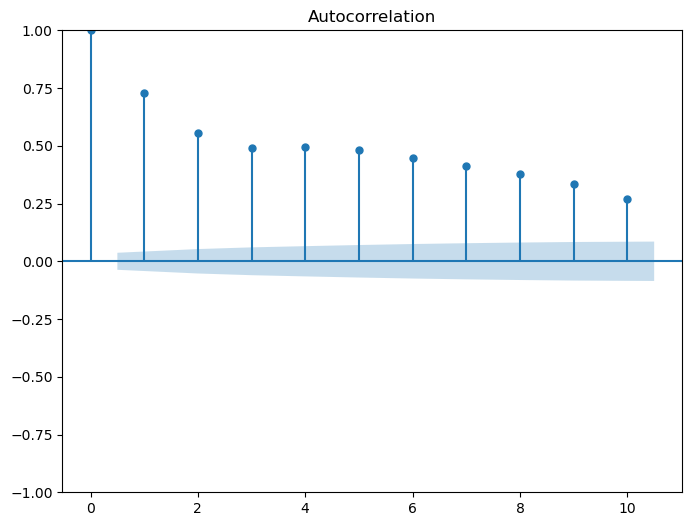

In [16348]:
sm.tsa.stattools.acf(test_df['target'], nlags=10, fft=False)

fig = plt.figure(figsize=(8,6))
fig.set_facecolor('white')
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(test_df['target'], lags=10, ax=ax)
plt.show()

In [16349]:
test_df['target']

date
2017-01-01    0.030805
2017-01-02    0.025695
2017-01-03    0.091135
2017-01-04    0.096505
2017-01-05    0.047494
                ...   
2024-09-26    0.003140
2024-09-27    0.000000
2024-09-28    0.009471
2024-09-29    0.010927
2024-09-30    0.002488
Name: target, Length: 2830, dtype: float64

In [16350]:
# plt.plot(test_df['target'])

In [16351]:
test_df = test_df.fillna(test_df.mean())

shifted_columns = test_df.columns.difference(['target'])
shifted_df = test_df[shifted_columns].shift(1)

shifted_columns = shifted_df.columns + '_shifted'
shifted_df.columns = shifted_columns

combined_df = pd.concat([shifted_df], axis=1)
combined_df['target'] = test_df['target']


In [16352]:
combined_df = combined_df.dropna()
combined_df

,abs_returns_shifted,avg-block-size_shifted,avg-confirmation-time_shifted,blocks-size_shifted,close_shifted,close_avg_15_shifted,close_avg_30_shifted,close_avg_5_shifted,cost-per-transaction_shifted,cost-per-transaction-percent_shifted,...,output-volume_shifted,returns_shifted,target_avg_5_shifted,target_returns_shifted,trade-volume_shifted,transaction-fees_shifted,transaction-fees-usd_shifted,transaction_amount_usd_shifted,volume_shifted,target
date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,0.058470,0.377989,0.008012,0.444073,0.015684,0.318888,0.318888,0.318888,0.243694,0.206983,...,0.061314,0.001612,0.051813,0.006942,0.065635,0.052364,0.017250,0.030805,0.000746,0.025695
2017-01-03,0.104388,0.245267,0.008012,0.000000,0.013155,0.318888,0.318888,0.318888,0.005898,0.110809,...,0.050474,-0.041238,0.051813,0.001112,0.001376,0.072178,0.000829,0.025695,0.001279,0.091135
2017-01-04,0.019476,0.226969,0.008012,0.000296,0.013608,0.318888,0.318888,0.318888,0.006118,0.090892,...,0.066050,0.007694,0.051813,0.004727,0.001679,0.075280,0.000902,0.091135,0.000202,0.096505
2017-01-05,0.032828,0.264942,0.008012,0.000589,0.012840,0.318888,0.318888,0.318888,0.004710,0.068694,...,0.088036,-0.012969,0.051813,0.001411,0.001884,0.126150,0.002064,0.096505,0.000314,0.047494
2017-01-06,0.043543,0.264050,0.008012,0.000887,0.011834,0.012384,0.012384,0.012384,0.004414,0.034669,...,0.109388,-0.017201,0.092528,0.000656,0.004816,0.073592,0.000916,0.047494,0.000610,0.072822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-26,0.043751,0.613143,0.004720,0.997680,0.858044,0.883286,0.883286,0.883286,0.177725,0.206983,...,0.019156,-0.017284,0.001597,0.006942,0.065635,0.000911,0.004654,0.000000,0.023139,0.003140
2024-09-27,0.081047,0.557142,0.007172,0.998167,0.886977,0.888636,0.888636,0.888636,0.173116,0.206983,...,0.020175,0.032018,0.002298,0.134620,0.065635,0.002173,0.006424,0.003140,0.037034,0.000000
2024-09-28,0.023147,0.623442,0.002156,0.998577,0.895505,0.895061,0.895061,0.895061,0.198076,0.206983,...,0.018774,0.009144,0.001562,0.000000,0.065635,0.003877,0.008480,0.000000,0.028712,0.009471


In [16353]:
test_df

,returns,close,abs_returns,volume,open,high,low,high_low,daily_avg_trades,daily_sum_trades,...,n-payments-per-block,n-payments,avg-confirmation-time,transaction_amount_usd,target,target_returns,target_avg_5,close_avg_5,close_avg_15,close_avg_30
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.001612,0.015684,0.058470,0.000746,0.015346,0.017147,0.020196,0.018747,0.097865,0.097794,...,0.344747,0.299529,0.008012,0.030805,0.030805,0.006942,0.051813,0.318888,0.318888,0.318888
2017-01-02,-0.041238,0.013155,0.104388,0.001279,0.015684,0.015532,0.016372,0.029674,0.097865,0.097794,...,0.344747,0.299529,0.008012,0.025695,0.025695,0.001112,0.051813,0.318888,0.318888,0.318888
2017-01-03,0.007694,0.013608,0.019476,0.000202,0.013155,0.012882,0.015077,0.022439,0.097865,0.097794,...,0.344747,0.299529,0.008012,0.091135,0.091135,0.004727,0.051813,0.318888,0.318888,0.318888
2017-01-04,-0.012969,0.012840,0.032828,0.000314,0.013608,0.013256,0.017742,0.010913,0.097865,0.097794,...,0.344747,0.299529,0.008012,0.096505,0.096505,0.001411,0.051813,0.318888,0.318888,0.318888
2017-01-05,-0.017201,0.011834,0.043543,0.000610,0.012840,0.011959,0.015979,0.013080,0.097865,0.097794,...,0.344747,0.299529,0.008012,0.047494,0.047494,0.000656,0.092528,0.012384,0.012384,0.012384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-26,0.032018,0.886977,0.081047,0.037034,0.858044,0.887405,0.873558,0.231546,0.286434,0.286716,...,0.539078,0.412748,0.007172,0.003140,0.003140,0.134620,0.002298,0.888636,0.888636,0.888636
2024-09-27,0.009144,0.895505,0.023147,0.028712,0.886977,0.896753,0.904936,0.121552,0.229749,0.229995,...,0.517784,0.426102,0.002156,0.000000,0.000000,0.000000,0.001562,0.895061,0.895061,0.895061
2024-09-28,0.001339,0.896765,0.003389,0.011710,0.895505,0.893377,0.913727,0.059555,0.088050,0.088204,...,0.575076,0.438451,0.002706,0.009471,0.009471,0.134620,0.004001,0.902443,0.902443,0.902443


### Target의 Returns 예측

In [16354]:
# 비트코인 이벤트
event_df = pd.read_csv("data/event/bitcoin_event.csv").set_index("Date")
event_df

,Event
Date,
2017-01-01,0
2017-01-02,0
2017-01-03,0
2017-01-04,0
2017-01-05,0
...,...
2024-12-28,0
2024-12-29,0
2024-12-30,0


In [16355]:
test_df_1 = test_df.copy()
test_df_1['event_flag'] = event_df
test_df_1['event_flag'] = test_df_1['event_flag'].shift(0)

In [16356]:
y = test_df_1['returns'].shift(-2).fillna(test_df_1['returns'].mean())
X = test_df_1[['target', 'volume', 'event_flag']].fillna(test_df_1.mean())

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS 기본 요약 ===")
print(lr.summary())

=== OLS 기본 요약 ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.410
Date:                Thu, 20 Feb 2025   Prob (F-statistic):             0.0661
Time:                        14:44:11   Log-Likelihood:                 1289.4
No. Observations:                 566   AIC:                            -2571.
Df Residuals:                     562   BIC:                            -2553.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001  

### Target의 Event 관측

In [16357]:
y = test_df_1['returns'].shift(-2).fillna(test_df_1['returns'].mean())
X = test_df_1[['target', 'volume', 'event_flag']].fillna(test_df_1.mean())

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.23, shuffle=False)

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS 기본 요약 ===")
print(lr.summary())

=== OLS 기본 요약 ===
                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     3.249
Date:                Thu, 20 Feb 2025   Prob (F-statistic):             0.0215
Time:                        14:44:11   Log-Likelihood:                 1475.9
No. Observations:                 651   AIC:                            -2944.
Df Residuals:                     647   BIC:                            -2926.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001  

In [16358]:
test_df_1 = test_df.copy()
test_df_1['event_flag'] = event_df
test_df_1['lag_event_flag'] = test_df_1['event_flag'].shift(-2)
test_df_1['lag_event_flag'] = test_df_1['lag_event_flag'].fillna(0)
test_df_1['lag_returns'] = test_df_1['returns'].shift(-2)
test_df_1['lag_returns'] = test_df_1['lag_returns'].fillna(0)
test_df_1['lag_volume'] = test_df_1['volume'].shift(-2)
test_df_1['lag_volume'] = test_df_1['lag_volume'].fillna(test_df_1.mean())

test_df_1['target_delta'] = test_df_1['target'].diff().shift(1)
test_df_1['target_delta'] = test_df_1['target_delta'].fillna(test_df_1['target_delta'].mean())

In [16359]:
y = test_df_1['lag_returns'].fillna(0)
X = test_df_1[['target_delta', 'lag_event_flag']].fillna(0)

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.73, shuffle=False)

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS 기본 요약 ===")
print(lr.summary())

=== OLS 기본 요약 ===
                            OLS Regression Results                            
Dep. Variable:            lag_returns   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.926
Date:                Thu, 20 Feb 2025   Prob (F-statistic):             0.0538
Time:                        14:44:12   Log-Likelihood:                 4008.8
No. Observations:                2066   AIC:                            -8012.
Df Residuals:                    2063   BIC:                            -7995.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0019 

In [16360]:
date_index = test_df_1.index

test_df_1['target_delta'] = test_df_1['target'].diff().shift(0)
test_df_1['target_delta'] = test_df_1['target_delta'].fillna(test_df_1['target_delta'].mean())

test_df_1.reset_index(drop=True, inplace=True)

# 이벤트 발생 인덱스 찾기
event_indices = test_df_1.index[test_df_1['event_flag'] == 1]

# 이벤트 중심 데이터 저장할 리스트
event_window = range(-3, 4)  # -10일 ~ +10일 윈도우
event_data = {day: [] for day in event_window}


# 각 이벤트 발생일을 기준으로 -10일 ~ +10일 데이터 수집
for event_idx in event_indices:
    for day in event_window:
        target_idx = event_idx + day
        if 0 <= target_idx < len(test_df_1):  # 인덱스 범위 체크
            event_data[day].append(test_df_1.loc[target_idx, 'target'])


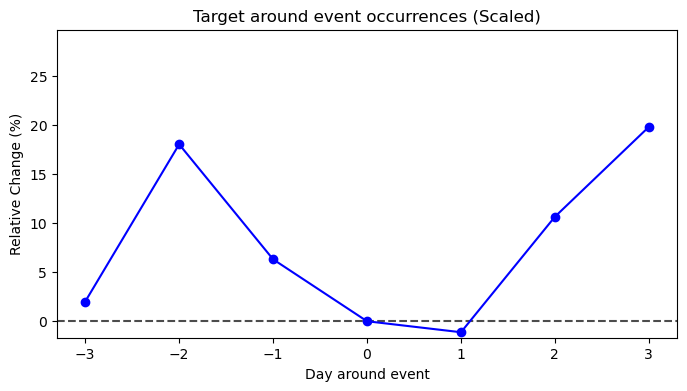

In [16361]:
# event_avg = {day: np.mean(event_data[day]) for day in event_window}
# event_std = {day: np.std(event_data[day]) / np.sqrt(len(event_data[day])) for day in event_window}  # 표준오차 (SE)

# event_transaction_df = pd.DataFrame({'Day': list(event_avg.keys()), 'Mean': list(event_avg.values()), 'SE': list(event_std.values())})

# plt.figure(figsize=(8, 6))
# plt.errorbar(event_transaction_df['Day'], event_transaction_df['Mean'], yerr=event_transaction_df['SE'], fmt='-o', color='blue', capsize=3)
# plt.axhline(0, linestyle='dashed', color='black', alpha=0.7)  # 0 축
# plt.xlabel("Day around event")
# plt.ylabel("Δ Target")
# plt.ylabel("Target")
# plt.title("Target around event occurrences")
# plt.show()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

event_avg = {day: np.mean(event_data[day]) for day in event_window}
event_std = {day: np.std(event_data[day]) / np.sqrt(len(event_data[day])) for day in event_window}  # 표준오차 (SE)

event_transaction_df = pd.DataFrame({'Day': list(event_avg.keys()), 'Mean': list(event_avg.values()), 'SE': list(event_std.values())})

baseline = event_transaction_df[event_transaction_df['Day'] == 0]['Mean'].values[0]  # 0일 기준
event_transaction_df['Relative Change (%)'] = ((event_transaction_df['Mean'] - baseline) / baseline) * 100
# event_transaction_df['SE (%)'] = (event_transaction_df['SE'] / baseline) * 10

plt.figure(figsize=(8, 4))
plt.errorbar(event_transaction_df['Day'], event_transaction_df['Relative Change (%)'],
             yerr=event_transaction_df['SE'], fmt='-o', color='blue', capsize=3)

plt.axhline(0, linestyle='dashed', color='black', alpha=0.7)  # 0 축
plt.xlabel("Day around event")
plt.ylabel("Relative Change (%)")
plt.title("Target around event occurrences (Scaled)")

plt.ylim(event_transaction_df['Relative Change (%)'].min() * 1.5, event_transaction_df['Relative Change (%)'].max() * 1.5)

plt.show()


### 이벤트 긍정 부정에 따른 수익률 예측

In [16362]:
event_sentiment_temp_df = pd.read_csv("data/event/bitcoin_event_details_sentiment.csv")
event_sentiment_temp_df = event_sentiment_temp_df[['Date', 'classification']]
event_sentiment_temp_df['Date'] = event_sentiment_temp_df['Date'] = event_sentiment_temp_df['Date'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
event_sentiment_temp_df = event_sentiment_temp_df.set_index('Date')

# 같은 날에 이벤트 2개 이상 발생 시 처리
event_sentiment_temp_df = event_sentiment_temp_df.groupby(event_sentiment_temp_df.index).mean()
event_sentiment_temp_df

,classification
Date,
2016-08-03,0.0
2017-11-25,1.5
2017-11-30,1.5
2017-12-04,1.5
2017-12-07,0.0
...,...
2022-11-11,0.0
2023-09-25,0.0
2024-01-10,1.0


In [16363]:
start_date = '2017-01-01'
end_date = '2025-01-01'
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

event_sentiment_df = pd.DataFrame(2, index=date_range, columns=['Event'])
event_sentiment_df.loc[event_sentiment_df.index.intersection(event_sentiment_temp_df.index)] = event_sentiment_temp_df['classification'].copy()
event_sentiment_df.columns = ['event_sentiment']

C:\Users\slaye\AppData\Local\Temp\ipykernel_34032\2112692679.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.5 1.5 1.5 0.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  2.  1.  2.  0.  1.  2.  0.  1.  1.  2.  0.  1.  2.
 1.  1.  0.5 1.  1.  1.  2.  0.  1.  1.  1.  2.  2.  1.  2.  1.  1.5 0.
 1.  2.  2.  1.  2.  1.  1.5 1.  2.  0.  2.  2.  2.  1.  2.  2.  2.  2.
 2.  2.  1.  2.  1.  1.  0.  2.  1.  1.  2.  1.  1.5 2.  1.  1.  2.  1.
 1.  1.  1.  1.  1.  2.  1.  2.  1.5 2.  1.  1.  1.5 1.  1.  1.  1.  0.
 1.  1.  1.  2.  0.  1.  0.  1.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.
 0.  0.  0.  0.  0.  0.  0.  1.  1.  1. ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  event_sentiment_df.loc[event_sentiment_df.index.intersection(event_sentiment_temp_df.index)] = event_sentiment_temp_df['classification'].copy()


In [16364]:
test_df_1 = test_df.copy()
test_df_1['event_flag'] = event_df
test_df_1['event_sentiment'] = event_sentiment_df
test_df_1['target_returns'] = test_df_1['target'].pct_change().fillna(0)
test_df_1['lag_event_flag'] = test_df_1['event_flag'].shift(-2).fillna(0)
test_df_1['lag_event_sentiment'] = test_df_1['event_sentiment'].shift(-2).fillna(2)
test_df_1['lag_returns'] = test_df_1['returns'].shift(-2).fillna(0)
test_df_1['lag_close'] = test_df_1['close'].shift(-2).fillna(method='ffill')
test_df_1['lag_volume'] = test_df_1['volume'].shift(-2).fillna(test_df_1.mean())


# test_df_1 = test_df_1[test_df_1['lag_event_sentiment']==0]

C:\Users\slaye\AppData\Local\Temp\ipykernel_34032\218962318.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df_1['lag_close'] = test_df_1['close'].shift(-2).fillna(method='ffill')


C:\Users\slaye\AppData\Local\Temp\ipykernel_34032\1709203238.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_target = plot_target/plot_target[0]
C:\Users\slaye\AppData\Local\Temp\ipykernel_34032\1709203238.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_price = plot_price/plot_price[0]
C:\Users\slaye\AppData\Local\Temp\ipykernel_34032\1709203238.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(plot_tar

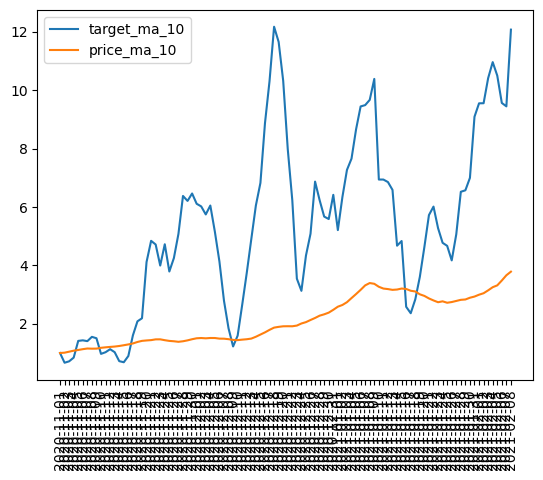

In [16365]:
start = 1400
end = 1500

plot_target = test_df_1.target
plot_target = plot_target/plot_target[0]
plot_price = test_df_1.close
plot_price = plot_price/plot_price[0]
plot_returns = test_df_1.returns
plot_target_returns = test_df_1.target_returns


plot_target_ma_10 = plot_target.rolling(5).mean().fillna(plot_target.mean())
plot_price_ma_10 = plot_price.rolling(5).mean().shift(-2).fillna(plot_target.mean())

# plt.plot(plot_target[start:end]/plot_target[start]/100, label='target')
# plt.plot(plot_price[start:end], label='price')
plt.plot(plot_target_ma_10[start:end]/plot_target_ma_10[start], label='target_ma_10')
plt.plot(plot_price_ma_10[start:end]/plot_price_ma_10[start], label='price_ma_10')
# plt.plot(plot_returns[start:end], label='returns')
# plt.plot(plot_target_returns[start:end]/30, label='target_returns)
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [16366]:
# y = test_df_1['lag_close']
# X = test_df_1[['target', 'lag_event_flag']].fillna(0)

y = test_df_1['lag_returns']
X = test_df_1[['target', 'lag_event_flag', 'lag_volume']].fillna(0)

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS 기본 요약 ===")
print(lr.summary())

=== OLS 기본 요약 ===
                            OLS Regression Results                            
Dep. Variable:            lag_returns   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.595
Date:                Thu, 20 Feb 2025   Prob (F-statistic):              0.190
Time:                        14:44:13   Log-Likelihood:                 949.99
No. Observations:                 425   AIC:                            -1892.
Df Residuals:                     421   BIC:                            -1876.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0018 

In [16367]:
# y = test_df_1['lag_close']
# X = test_df_1[['target', 'lag_event_flag']].fillna(0)

y = test_df_1['lag_returns']
X = test_df_1[['target', 'lag_event_flag', 'lag_volume']].fillna(0)

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS 기본 요약 ===")
print(lr.summary())

=== OLS 기본 요약 ===
                            OLS Regression Results                            
Dep. Variable:            lag_returns   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     3.586
Date:                Thu, 20 Feb 2025   Prob (F-statistic):             0.0137
Time:                        14:44:13   Log-Likelihood:                 1291.2
No. Observations:                 566   AIC:                            -2574.
Df Residuals:                     562   BIC:                            -2557.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0007 

In [16368]:
# 독립변수와 종속변수 정의
y = test_df_1['lag_returns']
X = test_df_1[['target', 'lag_event_flag', 'lag_volume']].fillna(0)

# train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

# 상수항 추가
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# OLS 회귀 모델 적합
lr = sm.OLS(y_train, X_train_const).fit()

# # OLS 요약 정보 출력
# print("=== OLS 기본 요약 train===")
# print(lr.summary())

# OLS 회귀 모델 적합
lr = sm.OLS(y_test, X_test_const).fit()

# OLS 요약 정보 출력
print("=== OLS 기본 요약 test===")
print(lr.summary())

# 📌 OLS 예측 수행
y_pred = lr.predict(X_test_const)

# # 예측값 확인
# print("=== OLS 예측값 ===")
# print(y_pred)

=== OLS 기본 요약 test===
                            OLS Regression Results                            
Dep. Variable:            lag_returns   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     3.586
Date:                Thu, 20 Feb 2025   Prob (F-statistic):             0.0137
Time:                        14:44:13   Log-Likelihood:                 1291.2
No. Observations:                 566   AIC:                            -2574.
Df Residuals:                     562   BIC:                            -2557.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0

In [16369]:
test_df_2 = test_df_1.copy()
test_df_2['lr_pred'] = y_pred
pred_mean = test_df_2['lr_pred'].median()
# test_df_2['trading_flag'] = test_df_2['lr_pred'].apply(lambda x: -1 if x < pred_mean else (1 if x > pred_mean else 0))

# # Good
# test_df_2['trading_flag'] = test_df_2['target'].apply(lambda x: -1 if x < (test_df_2['target'].mean()-0.16*test_df_2['target'].std()) else (1 if x > test_df_2['target'].mean() else 0))

# # MDD, Sharpe Nice
# test_df_2['trading_flag'] = test_df_2['target'].apply(lambda x: -1 if x < (test_df_2['target'].mean()-0.3*test_df_2['target'].std()) else (1 if x > test_df_2['target'].mean() else 0))

# test_df_2['trading_flag'] = test_df_2['target'].apply(lambda x: -1 if x < (test_df_2['target'].mean()-0.3*test_df_2['target'].std()) else (1 if x > test_df_2['target'].mean() else 0))


test_df_2['trading_flag'] = test_df_2['target'].apply(lambda x: -1 if x < (test_df_2['target'].mean()-0.2*test_df_2['target'].std()) else (1 if x > test_df_2['target'].mean() else 0))

test_df_2 = test_df_2.dropna()
test_df_2['trading_returns'] = test_df_2['trading_flag'] * test_df_2['returns']

In [16370]:
test_df_2['returns']

date
2023-03-15   -0.015596
2023-03-16    0.029364
2023-03-17    0.095859
2023-03-18   -0.017800
2023-03-19    0.039594
                ...   
2024-09-24    0.014568
2024-09-25   -0.017284
2024-09-26    0.032018
2024-09-27    0.009144
2024-09-28    0.001339
Name: returns, Length: 564, dtype: float64

In [16371]:
test_df_2_1 = test_df_2[test_df_2['trading_flag'] == 1]
test_df_2_2 = test_df_2[test_df_2['trading_flag'] == -1]

sharpe ratio:  2.042282407443718
cumulative returns:  2.464106940369959
MDD:  -0.20677489580701755


C:\Users\slaye\AppData\Local\Temp\ipykernel_34032\2054273963.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('cumulative returns: ', (test_df_2_2.lag_returns+1).cumprod()[-1])


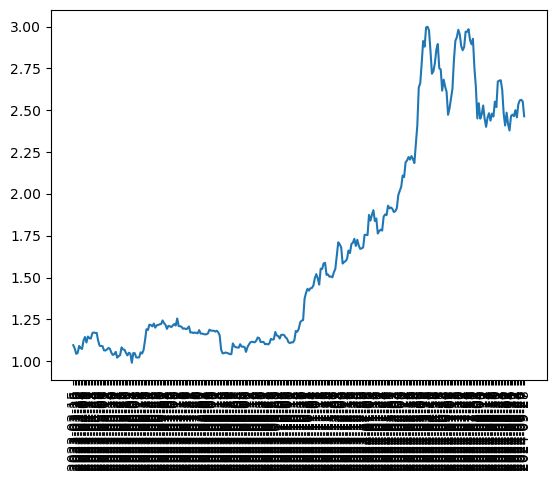

In [16372]:
# plt.plot((test_df_2_1.lag_returns+1).cumprod())
plt.plot((test_df_2_2.lag_returns+1).cumprod())
plt.xticks(rotation=90)
print('sharpe ratio: ', test_df_2_2['lag_returns'].mean()/test_df_2_2['lag_returns'].std()*np.sqrt(252))
print('cumulative returns: ', (test_df_2_2.lag_returns+1).cumprod()[-1])
print('MDD: ', calculate_mdd((test_df_2_2.lag_returns+1).cumprod()))


sharpe ratio:  1.2429684331466668
cumulative returns:  2.5332272214884397
MDD:  -0.26151375053867426


C:\Users\slaye\AppData\Local\Temp\ipykernel_34032\3373641484.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('cumulative returns: ', (test_df_2.lag_returns+1).cumprod()[-1])


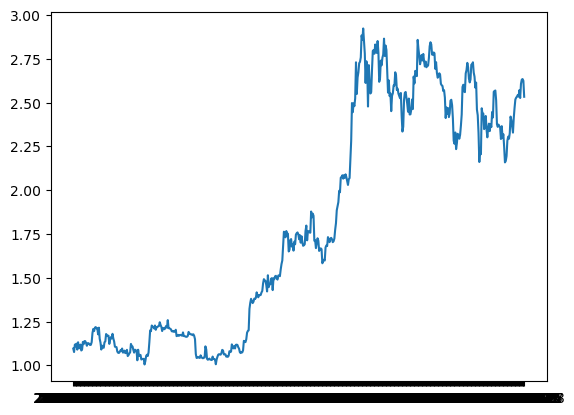

In [16373]:
plt.plot((test_df_2.lag_returns+1).cumprod())
print('sharpe ratio: ', test_df_2['lag_returns'].mean()/test_df_2['lag_returns'].std()*np.sqrt(252))
print('cumulative returns: ', (test_df_2.lag_returns+1).cumprod()[-1])
print('MDD: ', calculate_mdd((test_df_2.lag_returns+1).cumprod()))

### Transaction Amount와 Volume 관계

In [16374]:
test_df_1['target']
# test_df_1['volume']

date
2017-01-01    0.030805
2017-01-02    0.025695
2017-01-03    0.091135
2017-01-04    0.096505
2017-01-05    0.047494
                ...   
2024-09-26    0.003140
2024-09-27    0.000000
2024-09-28    0.009471
2024-09-29    0.010927
2024-09-30    0.002488
Name: target, Length: 2830, dtype: float64

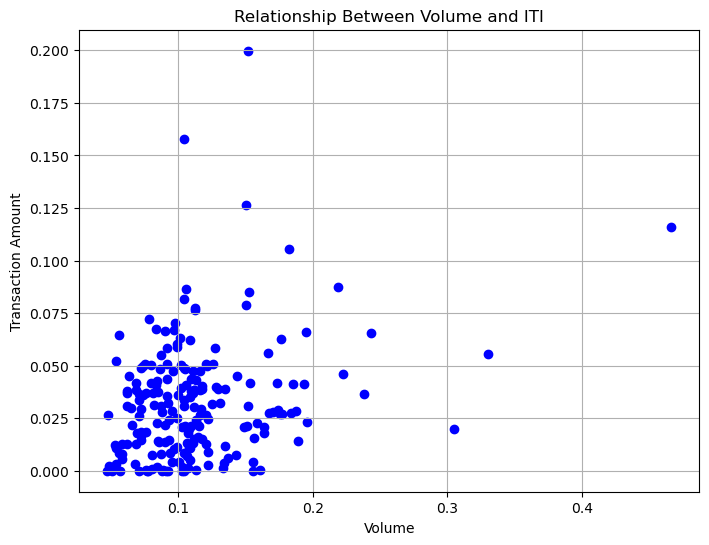

In [16375]:
# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.scatter(test_df_1['volume'].iloc[1400:1600], test_df_1['target'].iloc[1400:1600], marker='o', linestyle='-', color='b')

# 제목 및 레이블 추가
plt.title('Relationship Between Volume and ITI')
plt.xlabel('Volume')
plt.ylabel('Transaction Amount')

# 그리드 표시
plt.grid(True)

# 그래프 보여주기
plt.show()

c:\Users\slaye\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


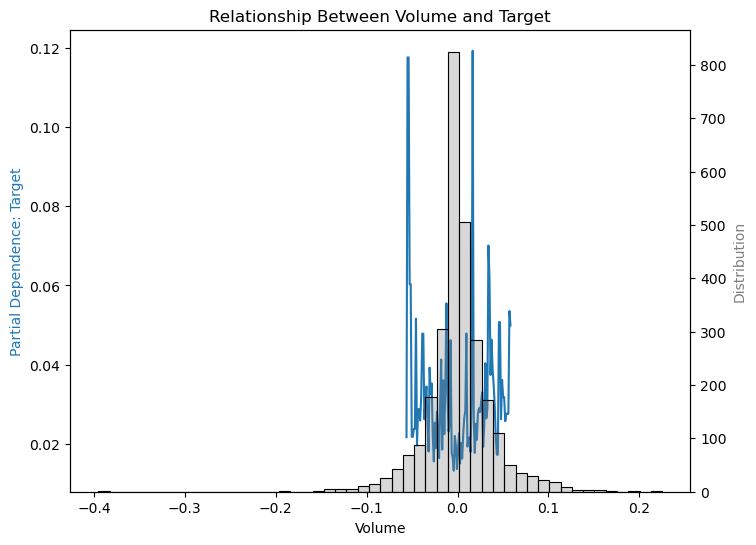

In [16376]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# 예제 데이터 생성 (실제 데이터에 맞게 수정)
np.random.seed(42)

# 1️⃣ X, y 데이터 정의
X = test_df_1[['returns']]  # 독립 변수
y = test_df_1['target']    # 종속 변수

# 2️⃣ 랜덤 포레스트 회귀 모델 학습 (비선형 관계를 잘 포착하기 위해 사용)
rf = XGBRegressor(n_estimators=10000, random_state=42)
rf.fit(X, y)

# 3️⃣ PDP 계산
pdp_results = partial_dependence(rf, X, features=[0])  # 0번 feature (volume) 선택

# 4️⃣ PDP 그래프 그리기
fig, ax1 = plt.subplots(figsize=(8, 6))

# PDP 라인 그래프
ax1.plot(pdp_results['values'][0], pdp_results['average'][0], color='tab:blue', label='Partial Dependence: Target')
ax1.set_xlabel("Volume")
ax1.set_ylabel("Partial Dependence: Target", color='tab:blue')

# Volume 히스토그램 추가
ax2 = ax1.twinx()
sns.histplot(X['returns'], bins=50, kde=False, color='gray', alpha=0.3, ax=ax2)
ax2.set_ylabel("Distribution", color='gray')

# 타이틀 및 스타일
plt.title("Relationship Between Volume and Target")
plt.show()


In [16377]:
np.corrcoef([test_df_1['volume'].iloc[1400:1600], test_df_1['target'].iloc[1400:1600]])

array([[1.        , 0.28999267],
       [0.28999267, 1.        ]])

<!-- ### XGBoost 학습 -->

In [16378]:
# # 스케일링
# scaler = MinMaxScaler()

# scaled_df = pd.DataFrame(scaler.fit_transform(combined_df), columns=combined_df.columns)

# ITI_scaler = MinMaxScaler()
# ITI_scaler.fit_transform(combined_df.target.values.reshape(-1,1))

# # # scaled_df['target'] = combined_df.target.values

# # scaled_df = np.log1p(combined_df)


In [16379]:
# y = combined_df['target'].values

# # 기존 X
# X = combined_df.drop('target', axis=1)

# ## train, test 데이터 분리
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


# # 스케일링
# scaler = MinMaxScaler()
# scaler.fit_transform(X_train)
# scaled_df = pd.DataFrame(scaler.transform(X), columns=X.columns)

# ITI_scaler = MinMaxScaler()
# ITI_scaler.fit(y_train.reshape(-1,1))

# # # # 선택된 X
# # selected_columns = [
# # 'avg-block-size_shifted', 'blocks-size_shifted',
# #        'cost-per-transaction_shifted', 'difficulty_shifted',
# #        'estimated-transaction-volume-usd_shifted', 'hash-rate_shifted',
# #        'market-price_shifted', 'miners-revenue_shifted',
# #        'n-unique-addresses_shifted', 'transaction-fees_shifted',
# #  'daily_avg_spread_shifted']
# # X = scaled_df[selected_columns]

In [16380]:
# # shift 1, Linear Regression
# lr = LinearRegression(fit_intercept=True)
# lr.fit(X_train, y_train)
# print('훈련 세트 R2 :', lr.score(X_train, y_train))

# # 테스트 셋 예측
# lr_y_pred = lr.predict(X_test)

# # 정확도
# predict_df = pd.DataFrame({'y_test': y_test, 'y_pred': lr_y_pred})
# predict_df['diff'] = predict_df['y_test'] - predict_df['y_pred']
# predict_df['diff_abs'] = predict_df['diff'].abs()
# predict_df['diff_squared'] = predict_df['diff']**2
# print("MAE:", predict_df['diff_abs'].mean())
# print("MSE:", predict_df['diff_squared'].mean())
# print("R2:", lr.score(X_test, y_test))

In [16381]:
# # # 현재 모델
# # XGBR = XGBRegressor(n_estimators=100000, gamma=0.002, subsample=0.75, learning_rate=0.07, max_depth=3, objective='reg:squarederror')
# # XGBR.fit(X_train, y_train)

# # predict_df = pd.DataFrame({'y_test': y_test, 'y_pred': XGBR.predict(X_test)})
# # predict_df['diff'] = predict_df['y_test'] - predict_df['y_pred']
# # predict_df['diff_abs'] = predict_df['diff'].abs()
# # predict_df['diff_squared'] = predict_df['diff']**2
# # print("MAE:", predict_df['diff_abs'].mean())
# # print("MSE:", predict_df['diff_squared'].mean())
# # print("R2:", XGBR.score(X_test, y_test))

# # XGBR.save_model('models/xgb_model_event_informed_amount_250211.json')


# # 현재 모델
# XGBR = XGBRegressor(n_estimators=100000, gamma=0.0021, subsample=0.75, learning_rate=0.069, max_depth=3, objective='reg:squarederror')
# XGBR.fit(X_train, y_train)

# predict_df = pd.DataFrame({'y_test': y_test, 'y_pred': XGBR.predict(X_test)})
# predict_df['diff'] = predict_df['y_test'] - predict_df['y_pred']
# predict_df['diff_abs'] = predict_df['diff'].abs()
# predict_df['diff_squared'] = predict_df['diff']**2
# print("MAE:", predict_df['diff_abs'].mean())
# print("MSE:", predict_df['diff_squared'].mean())
# print("R2:", XGBR.score(X_test, y_test))

# XGBR.save_model('models/xgb_model_event_informed_amount_250211.json')

In [16382]:
# import pandas as pd
# import numpy as np
# from xgboost import XGBRegressor
# from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# # 이미 X_train, y_train, X_test, y_test가 정의되어 있다고 가정합니다.
# # 예: X_train, y_train, X_test, y_test = ... (시계열 데이터 분할)

# # 최적화할 하이퍼파라미터 그리드 정의
# param_grid = {
#     'n_estimators': [5000, 10000, 20000],
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.001, 0.005, 0.01],
#     'gamma': [0, 0.002, 0.005],
#     'subsample': [0.6, 0.75, 0.9]
# }

# # XGBRegressor 객체 생성 (random_state와 n_jobs는 재현성과 속도 개선을 위해 설정)
# xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# # 시계열 데이터에 적합한 TimeSeriesSplit 사용 (n_splits는 데이터에 따라 조절)
# tscv = TimeSeriesSplit(n_splits=5)

# # GridSearchCV 설정
# grid_search = GridSearchCV(estimator=xgb_reg,
#                            param_grid=param_grid,
#                            scoring='neg_mean_squared_error',  # 회귀 문제에서는 MSE 사용 (음수로 반환됨)
#                            cv=tscv,
#                            verbose=1,
#                            n_jobs=-1)

# # 그리드 서치 실행
# grid_search.fit(X_train, y_train)

# # 최적 파라미터와 성능 출력
# print("최적 파라미터:", grid_search.best_params_)
# print("최적 음수 MSE:", grid_search.best_score_)
# print("최적 MSE:", -grid_search.best_score_)

# # 최적 모델로 예측 수행
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

# # 예측 결과 평가
# predict_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
# predict_df['diff'] = predict_df['y_test'] - predict_df['y_pred']
# predict_df['diff_abs'] = predict_df['diff'].abs()
# predict_df['diff_squared'] = predict_df['diff'] ** 2

# print("MAE:", predict_df['diff_abs'].mean())
# print("MSE:", predict_df['diff_squared'].mean())
# print("R2:", best_model.score(X_test, y_test))

# # 필요시 최적 모델 저장 (JSON 형식)
# best_model.save_model('models/xgb_model_optimized.json')


In [16383]:
# # 모델 불러오기
# XGBR = XGBRegressor()
# XGBR.load_model('models/xgb_model_event_informed_amount_250211.json')

# # Error, R2 평가
# predict_df = pd.DataFrame({'y_test': y_test, 'y_pred': XGBR.predict(X_test)})
# predict_df['diff'] = predict_df['y_test'] - predict_df['y_pred']
# predict_df['diff_abs'] = predict_df['diff'].abs()
# predict_df['diff_squared'] = predict_df['diff']**2
# print("MAE:", predict_df['diff_abs'].mean())
# print("MSE:", predict_df['diff_squared'].mean())
# print("R2:", XGBR.score(X_test, y_test))

In [16384]:
# from sklearn.feature_selection import RFE
# from xgboost import XGBRegressor

# model = XGBRegressor(n_estimators=50000, gamma=0.002, subsample=0.75, learning_rate=0.001, max_depth=3, objective='reg:squarederror')
# rfe = RFE(model, n_features_to_select=10)  # 선택할 변수 개수 지정
# rfe.fit(X_train, y_train)

# # 선택된 변수 확인
# selected_features = X_train.columns[rfe.support_]
# print("선택된 변수:", selected_features)

In [16385]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # 상관계수 행렬 계산 및 히트맵 시각화
# corr_matrix = scaled_df.corr()
# sns.heatmap(corr_matrix, annot=True, fmt=".2f")
# plt.show()

In [16386]:
# scaled_df

In [16387]:
# import seaborn as sns
# import numpy as np

# # feature별 importance 매핑
# for name, value in zip(selected_columns , XGBR.feature_importances_):
#     print('{0} : {1:.3f}'.format(name, value))

# # feature importance를 column 별로 시각화 하기 
# sns.barplot(x=XGBR.feature_importances_ , y=selected_columns)

In [16388]:
## 변수 선택

# 'avg-block-size_shifted', 'blocks-size_shifted',
#        'cost-per-transaction_shifted', 'difficulty_shifted',
#        'estimated-transaction-volume-usd_shifted', 'hash-rate_shifted',
#        'market-price_shifted', 'miners-revenue_shifted',
#        'n-unique-addresses_shifted', 'transaction-fees_shifted
#  daily_avg_spread_shifted

In [16389]:
# import pandas as pd
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# import joblib

# # Create and fit the RandomForestRegressor
# # Adjust hyperparameters (n_estimators, max_depth, etc.) as needed for your problem.
# RF = RandomForestRegressor(n_estimators=30000, max_depth=3, random_state=42)
# RF.fit(X_train, y_train)

# # Generate predictions on the test set
# predict_df = pd.DataFrame({
#     'y_test': y_test,
#     'y_pred': RF.predict(X_test)
# })

# # Calculate the difference, absolute difference, and squared difference
# predict_df['diff'] = predict_df['y_test'] - predict_df['y_pred']
# predict_df['diff_abs'] = predict_df['diff'].abs()
# predict_df['diff_squared'] = predict_df['diff']**2

# # Print evaluation metrics
# print("MAE:", predict_df['diff_abs'].mean())
# print("MSE:", predict_df['diff_squared'].mean())
# print("R2:", RF.score(X_test, y_test))

# # Save the model using joblib
# joblib.dump(RF, 'models/rf_model_event_informed_amount_250211.pkl')

# # 모델 로드
# import joblib
# import pandas as pd

# # Load the previously saved Random Forest model
# RF = joblib.load('models/rf_model_event_informed_amount_250211.pkl')

# # Evaluate the model
# predict_df = pd.DataFrame({
#     'y_test': y_test,
#     'y_pred': RF.predict(X_test)
# })
# predict_df['diff'] = predict_df['y_test'] - predict_df['y_pred']
# predict_df['diff_abs'] = predict_df['diff'].abs()
# predict_df['diff_squared'] = predict_df['diff'] ** 2

# print("MAE:", predict_df['diff_abs'].mean())
# print("MSE:", predict_df['diff_squared'].mean())
# print("R2:", RF.score(X_test, y_test))

In [16390]:
# xxx_amount = XGBR.predict(X)
# test_X = copy.deepcopy(X)
# test_X['ITI_amount'] = xxx_amount
# test_X.index = combined_df.index
# test_X

In [16391]:
# test_X[['ITI_amount']].to_csv("data/iti/event_ITI_amount_250211.csv", index=True)

In [16392]:
# ITI_amount = pd.read_csv("data/iti/event_ITI_amount_250211.csv")
# ITI_amount = ITI_amount.set_index('date')
# ITI_amount['ITI_amount'] = ITI_scaler.inverse_transform(ITI_amount)
# ITI_amount

### 기존 Target 예측

In [16393]:
# # 실제 트레이딩 확인 (변수명은 그대로)
# reversion_df = target_event_receive_df.copy()
# reversion_df = reversion_df[['date', 'transaction_amount']]
# reversion_df.columns = ['date', 'target']
# reversion_df = reversion_df.set_index('date')

# # 내일 target 예측
# reversion_df = reversion_df.shift(-1).dropna()
# reversion_df

In [16394]:
# result_df = pd.concat([ITI_amount, reversion_df], axis=1)
# result_df = result_df.dropna()

In [16395]:
# result_df

In [16396]:
# y = result_df['target'].values
# X = result_df['ITI_amount']

# ## train, test 데이터 분리
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False, random_state=0)

In [16397]:
# X_with_const = sm.add_constant(X_test)

# # OLS 회귀 적합
# # ---------------------------------------------
# lr = sm.OLS(y_test, X_with_const).fit()
# # print("=== OLS 기본 요약 ===")
# # print(lr.summary())

# # 로버스트 공분산(이분산 robust: HC1) 적용
# # ---------------------------------------------
# lr_hc1 = lr.get_robustcov_results(cov_type='HC1')
# print("\n=== 로버스트(HC1) 요약 ===")
# print(lr_hc1.summary())


### Returns 예측

In [16398]:
# test_target_df = test_df['returns'].shift(-3).dropna()


# test_target_df = pd.concat([ITI_amount, test_target_df], axis=1)
# test_target_df = test_target_df.dropna()

# test_target_df.columns = ['ITI_amount', 'target']
# test_target_df

In [16399]:
# y = test_target_df['target'].values
# X = test_target_df[['ITI_amount']]

# ## train, test 데이터 분리
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.139, shuffle=False, random_state=0)

# X_with_const = sm.add_constant(X_test)

# # OLS 회귀 적합
# # ---------------------------------------------
# lr = sm.OLS(y_test, X_with_const).fit()
# # print("=== OLS 기본 요약 ===")
# # print(lr.summary())

# # 로버스트 공분산(이분산 robust: HC1) 적용
# # ---------------------------------------------
# lr_hc1 = lr.get_robustcov_results(cov_type='HC1')
# print("\n=== 로버스트(HC1) 요약 ===")
# print(lr_hc1.summary())


### Event 예측

In [16400]:
# # 비트코인 이벤트
# event_df = pd.read_csv("data/event/bitcoin_event.csv")

In [16401]:
# test_target_df = test_df['returns'].shift(-2).dropna()


# test_target_df = pd.concat([ITI_amount, test_target_df], axis=1)
# test_target_df = test_target_df.dropna()

# test_target_df.columns = ['ITI_amount', 'target']
# test_target_df

In [16402]:
# test_target_receive_df = target_event_receive_df.set_index('date').copy()

In [16403]:
# # 실제값 이벤트 예측용
# test_target_df['transaction_amount'] = test_target_receive_df['transaction_amount']
# test_target_df['transaction_count'] = test_target_receive_df['transaction_count']
# test_target_df['transaction_flag'] = test_target_receive_df['transaction_flag']

# test_target_df['transaction_amount'] = test_target_df['transaction_amount'].apply(lambda x: 0.000001 if x == 0 else x)
# test_target_df['transaction_amount_returns'] = test_target_df['transaction_amount'].pct_change(1).fillna(0)

In [16404]:
# event_df = event_df.set_index('Date')

In [16405]:
# test_target_df['event_flag'] = (event_df[(event_df.index>=list(test_target_df.index)[0])&(event_df.index<=list(test_target_df.index)[-1])]['Event'])
# test_target_df

In [16406]:
# test_target_df['event_flag_lag_2'] = test_target_df['event_flag'].shift(-2).fillna(0)
# test_target_df